In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 1. Load shapefiles and project to same CRS

In [2]:
# load shapefiles
tracts = gpd.read_file('NYC_censustracts')
beds = gpd.read_file('NYC_hospitalbeds')

In [3]:
# check if same CRS
tracts.crs == beds.crs

False

In [4]:
# set new CRS and verify
ny_crs = "ESRI:102718"

tracts = tracts.to_crs(ny_crs)
beds = beds.to_crs(ny_crs)

tracts.crs == beds.crs

True

## 2. Load ACS data, merge with tract shapefile, and obtain tract centroids

In [5]:
# load csv and inspect
acs = pd.read_csv('ACS_NewYork_agesex_2019.csv',
                  dtype={'GEOID': 'str'})
acs.head()

,ID2,GEOID,NAME,Total,Male,Female
0,1400000U,36005000100,"Census Tract 1, Bronx County, New York",6864,6345,519
1,1400000U,36005000200,"Census Tract 2, Bronx County, New York",4532,2193,2339
2,1400000U,36005000400,"Census Tract 4, Bronx County, New York",5516,2810,2706
3,1400000U,36005001600,"Census Tract 16, Bronx County, New York",5825,2422,3403
4,1400000U,36005001900,"Census Tract 19, Bronx County, New York",3141,1583,1558


In [6]:
# merge tract shapefile and ACS csv
gdf = tracts.merge(acs, how='left', left_on='GEOID', right_on='GEOID')
len(tracts) == len(gdf)

True

In [7]:
# drop weird Central Park census tract (pop of 2?)
gdf = gdf.drop(416)

In [8]:
# get centroids
c = gdf.copy()
c['geometry'] = c['geometry'].centroid

## 3.1. Calculate beds-to-pop ratio of each hospital

In [9]:
# set distance as 3 miles (15840 feet)
distance = 15840

In [10]:
# calculate hospital buffer
hbuf = beds.copy()
hbuf['geometry'] = hbuf['geometry'].buffer(distance=distance)

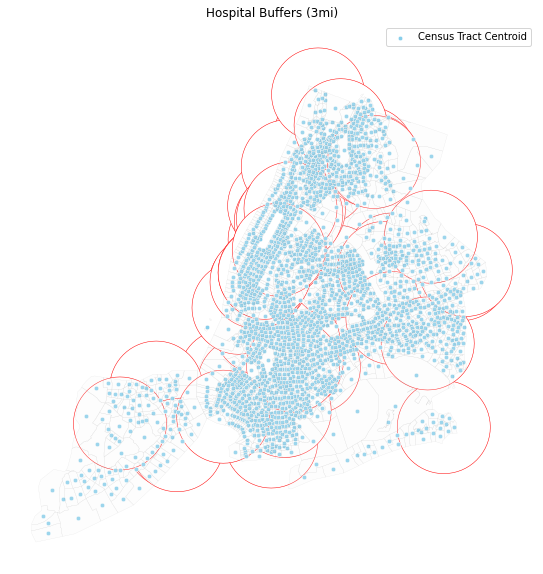

In [11]:
# plot tracts on top of hospital buffers
fig, ax = plt.subplots(figsize=(10, 10))

hbuf.plot(ax=ax, facecolor='white', edgecolor='red', linewidth=0.5)
c.plot(ax=ax, facecolor='skyblue', markersize=20, edgecolor='white',
       linewidth=0.5, label='Census Tract Centroid')
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='dimgray', linewidth=0.2, alpha=0.2)

plt.title(label='Hospital Buffers (3mi)')
plt.axis('off')
plt.legend()

plt.savefig('hospital_buff.jpg', dpi=600, bbox_inches='tight')

In [12]:
# spatial join hospital catchment to tract centroids (creates duplicates)
j = gpd.sjoin(hbuf, c, how='left', op='intersects')

# group all tracts by tract ID to create "total pop within catchment area" variable
pop1km = j.groupby('OBJECTID')['Total'].sum()
pop1km = pop1km.rename('pop1km')

# re-merge summed pop variable with hospital buffer geodataframe
df1 = hbuf.merge(pop1km, how='left', left_on='OBJECTID', right_on='OBJECTID')

# verify that result has correct number of hospitals
len(pop1km) == len(df1) == len(beds)

True

In [13]:
# calculate hospital beds-to-pop ratio
df1['b2p'] = df1['NUM_STAFFE'] / df1['pop1km']

## 3.2. Calculate overall health accessibility of each tract

In [14]:
# calculate buffer
cbuf = c.copy()
cbuf['geometry'] = cbuf['geometry'].buffer(distance=distance)

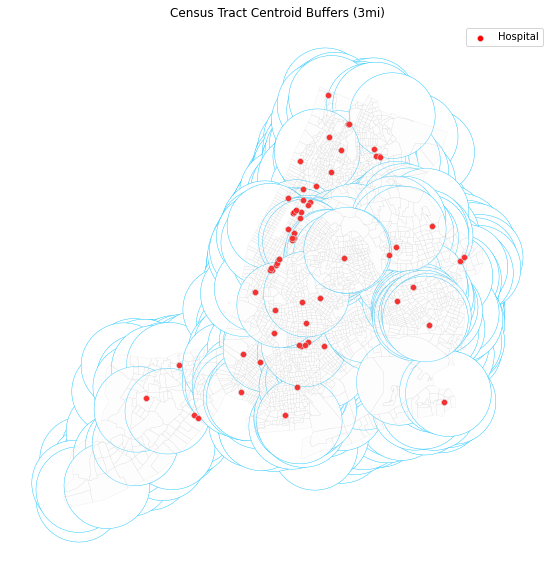

In [15]:
# plot hospital beds on top of tract centroid buffers
fig, ax = plt.subplots(figsize=(10, 10))
cbuf.plot(ax=ax, facecolor='white', edgecolor='deepskyblue', linewidth=0.4)
beds.plot(ax=ax, facecolor='red', edgecolor='lightgray', linewidth=0.5, label='Hospital')
gdf.plot(ax=ax, facecolor='whitesmoke', edgecolor='dimgray', linewidth=0.2, alpha=0.2)

plt.title(label='Census Tract Centroid Buffers (3mi)')
plt.legend()
ax.axis('off')

plt.savefig('tract_buff.jpg', dpi=600, bbox_inches='tight')

In [16]:
# spatial join beds to tracts (creates duplicate tracts for every intersected hospital and tract)
j = gpd.sjoin(cbuf, beds, how='left', op='intersects')

# group all tracts by tract ID and add all beds together
beds1km = j.groupby('GEOID')['NUM_STAFFE'].sum()
beds1km = beds1km.rename('beds1km')

# re-merge summed beds data with tract centroid buffer geodataframe
df2 = cbuf.merge(beds1km, how='left', left_on='GEOID', right_on='GEOID')

# verify that output has the correct number of tracts
len(df2) == len(beds1km) == len(gdf)

True

In [17]:
# calculate tract beds-to-pop ratio
df2['b2p'] = df2['beds1km'] / df2['Total']

# replace all infinite values (where Total pop is 0) with 0s
df2.loc[df2['Total'] == 0, 'b2p'] = 0

## 3.3. Calculate 2SFCA

In [18]:
# distance_matrix function from SciPy calculates distances between tract centroids and hospitals
from scipy.spatial import distance_matrix

# Aceso is a Python package for measuring spatial accessibility (including 2SFCA model)
import aceso as aceso

In [19]:
# convert tract centroid and hospital geometry columns into X and Y coordinates
c['lon'] = c['geometry'].x
c['lat'] = c['geometry'].y
beds['lon'] = beds['geometry'].x
beds['lat'] = beds['geometry'].y

In [20]:
# drop all variables except for coordinates
h = beds[['lon', 'lat']]
t = c[['lon', 'lat']]

In [21]:
# calculate distance matrix
matrix = pd.DataFrame(distance_matrix(t, h))
matrix

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,68570.473112,49962.596932,72444.029129,57019.386429,75709.011008,65896.943968,10009.058336,27154.092799,17911.102100,20050.479025,...,28800.555844,77663.543398,70380.756533,15812.305316,71331.961315,43237.703071,19769.914843,19655.706512,53699.138127,28728.993000
1,68217.831773,49546.097101,71727.892067,56513.271530,75256.118657,65404.847270,9126.126794,25668.789938,18351.065916,18747.190985,...,28391.548815,76181.906513,69054.334919,15715.211719,70545.679529,42908.269659,19507.982714,19388.420165,54831.076017,28342.419697
2,67313.132397,48613.408014,70651.737368,55533.595433,74298.775309,64429.963552,9353.021825,25068.603140,19357.751101,18435.822553,...,27477.141059,74991.797321,67832.921563,15017.906712,69442.102988,42024.742577,18693.474094,18571.121702,56039.477096,27440.110130
3,65891.939846,47217.946826,69446.651831,54188.489673,72928.473682,63079.165194,10928.834087,26124.362204,20674.773587,19765.791343,...,26064.044323,74781.601191,67304.929668,13467.741285,68290.712463,40585.331251,17202.203427,17081.589857,56843.389144,26016.055520
4,85487.063632,66830.662342,88753.484089,73783.128656,92539.511942,82678.712918,12446.375679,28753.945378,1527.123506,20049.910957,...,45672.714356,87873.742497,82980.453486,32746.505610,87423.152746,60163.459906,36709.921014,36594.439125,40897.231855,45618.039559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,42783.255002,26832.106192,38696.609138,29705.177670,46905.682051,37356.464901,41045.213015,36384.017230,54685.857552,39440.922096,...,21019.343916,42799.085588,32179.990367,29166.657315,36416.886611,25223.746213,25907.202542,25895.715531,92645.223021,21434.719728
2319,74083.250741,61689.936052,63376.245855,62287.145517,75403.967358,67674.150119,55981.960882,38843.413831,68666.760166,47227.214595,...,55735.407977,25574.323823,32258.630864,58795.588961,59879.495954,61245.039427,57234.424782,57162.873180,107545.424076,56135.874139
2320,42479.976169,26364.384276,38668.044587,29378.087560,46707.635981,37113.649385,40755.358960,36421.100619,54359.209459,39329.046817,...,20335.087777,43465.581582,32756.121924,28570.560703,36442.166256,24638.571928,25279.716093,25269.691316,92232.221818,20750.434336
2321,75919.080652,63659.855814,65015.404178,64188.427250,77135.478003,69490.683164,57447.132802,40035.823861,69995.591530,48506.742292,...,57740.916450,25695.720396,33355.076557,60695.768505,61495.634139,63253.086047,59176.641425,59104.004745,108754.790624,58140.906367


In [22]:
# implement 2SFCA model and capture results in census tract geodataframe
model = aceso.TwoStepFCA(radius=distance)
gdf['access'] = model.calculate_accessibility_scores(distance_matrix=matrix,
                                                     supply_array=df1['pop1km'].values,
                                                     demand_array=df2['beds1km'].values)

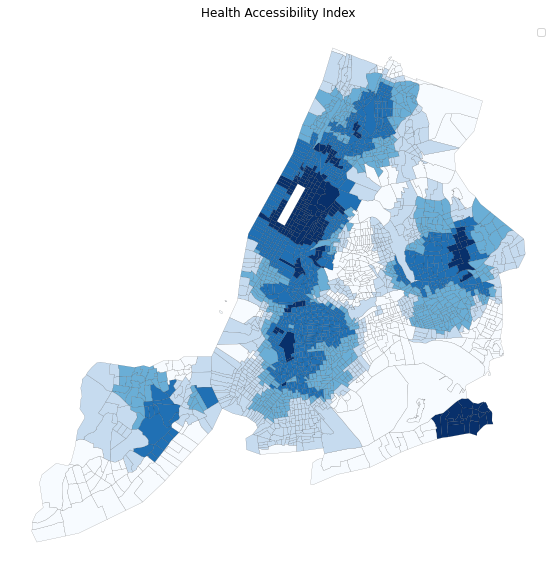

In [23]:
# plot result
fig, ax = plt.subplots(figsize=(10, 10))
g = gdf.plot(ax=ax, column='access', scheme='NaturalBreaks', cmap='Blues',
             edgecolor='black', linewidth=0.1, legend=True, label='Health Accessibility Index')

plt.title(label='Health Accessibility Index')
plt.legend(['Health Accessibility Index'])
ax.axis('off')

plt.savefig('choro_2SFCA.jpg', dpi=600, bbox_inches='tight')

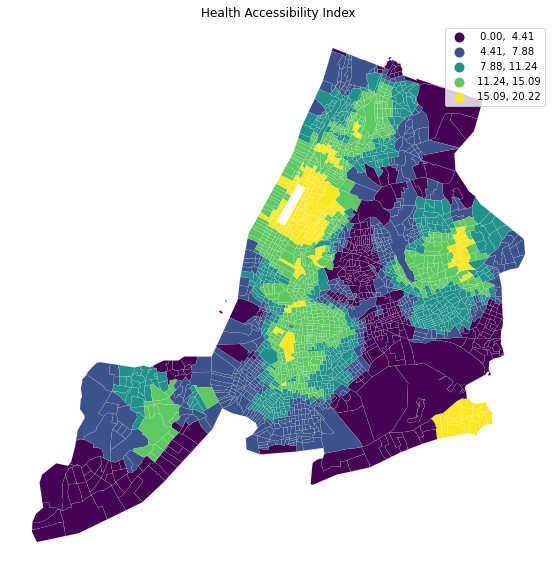

In [38]:
cmap = plt.colormaps['viridis']
fig, ax = plt.subplots(figsize=(10, 10))

g = gdf.plot(ax=ax,
             column='access',
             scheme='NaturalBreaks',
             cmap=cmap,
             edgecolor='white',
             linewidth=0.1,
             legend=True)

plt.title(label='Health Accessibility Index')#New York City Census Tracts')
ax.set_axis_off()
